# Read Data

In [1]:
import pandas as pd

# Read the CSV file into a DataFrame
df = pd.read_csv('SOL_USDT_futures_data_2020.csv')

# Drop unnecessary columns
df.drop(columns=(['coin','volume','closetime','quotevolume','trades','taker_buy_volume','taker_buy_quote','unused']), inplace=True)

# Display the first few rows of the DataFrame
df

,opentime,openprice,highprice,lowprice,closeprice
0,1600066800000,3.2002,4.9100,3.2002,3.3666
1,1600070400000,3.3663,3.5650,3.3000,3.3298
2,1600074000000,3.3298,3.3567,3.2161,3.2755
3,1600077600000,3.2753,3.3873,3.2500,3.3673
4,1600081200000,3.3686,3.4600,3.3200,3.3799
...,...,...,...,...,...
37649,1735603200000,191.2600,191.9600,189.9000,189.9800
37650,1735606800000,189.9900,190.3600,188.2400,189.1000
37651,1735610400000,189.1000,190.7500,188.7100,190.1900
37652,1735614000000,190.1900,190.6900,189.3900,189.8400


# Add Super Trend Indicator

In [3]:
import pandas as pd
import numpy as np
from pandas_ta.overlap import hl2
from pandas_ta.volatility import atr
from pandas_ta.utils import get_offset, verify_series

npNaN = np.nan

# Apply the Supertrend function
def supertrend(high, low, close, length=7, multiplier=3.0, offset=0, **kwargs):
    """Indicator: Supertrend"""
    # Validate Arguments
    high = verify_series(high, length)
    low = verify_series(low, length)
    close = verify_series(close, length)
    offset = get_offset(offset)

    if high is None or low is None or close is None:
        return

    m = close.size
    dir_, trend = [1] * m, [0] * m
    long, short = [np.nan] * m, [np.nan] * m

    hl2_ = hl2(high, low)
    matr = multiplier * atr(high, low, close, length)
    upperband = hl2_ + matr
    lowerband = hl2_ - matr

    for i in range(1, m):
        if close.iloc[i] > upperband.iloc[i - 1]:
            dir_[i] = 1
        elif close.iloc[i] < lowerband.iloc[i - 1]:
            dir_[i] = -1
        else:
            dir_[i] = dir_[i - 1]
            if dir_[i] > 0 and lowerband.iloc[i] < lowerband.iloc[i - 1]:
                lowerband.iloc[i] = lowerband.iloc[i - 1]
            if dir_[i] < 0 and upperband.iloc[i] > upperband.iloc[i - 1]:
                upperband.iloc[i] = upperband.iloc[i - 1]

        if dir_[i] > 0:
            trend[i] = long[i] = lowerband.iloc[i]
        else:
            trend[i] = short[i] = upperband.iloc[i]

    # Prepare DataFrame to return
    _props = f"_{length}_{multiplier}"
    df = pd.DataFrame({
        f"SUPERT{_props}": trend,
        f"SUPERTd{_props}": dir_,
        f"SUPERTl{_props}": long,
        f"SUPERTs{_props}": short,
    }, index=close.index)

    df.name = f"SUPERT{_props}"
    df.category = "overlap"

    # Apply offset if needed
    if offset != 0:
        df = df.shift(offset)

    # Handle fills
    if "fillna" in kwargs:
        df.fillna(kwargs["fillna"], inplace=True)

    if "fill_method" in kwargs:
        df.fillna(method=kwargs["fill_method"], inplace=True)

    return df

1. length = 12, multiplier = 3
2. length = 11, multiplier = 2
1. length = 10, multiplier = 1

In [32]:
# Get the Supertrend values using the 'highprice', 'lowprice', and 'closeprice' columns
supertrend_indicator_1 = supertrend(df['highprice'], df['lowprice'], df['closeprice'], length=12, multiplier=3.0)
supertrend_indicator_2 = supertrend(df['highprice'], df['lowprice'], df['closeprice'], length=11, multiplier=2.0)
supertrend_indicator_3 = supertrend(df['highprice'], df['lowprice'], df['closeprice'], length=10, multiplier=1.0)

# Join the Supertrend indicator values to your original dataframe
supertrend_df = df.join(supertrend_indicator_1)
supertrend_df = supertrend_df.join(supertrend_indicator_2)
supertrend_df = supertrend_df.join(supertrend_indicator_3)

# Drop unnecessary columns
supertrend_df.drop(columns=(['SUPERT_12_3.0','SUPERTd_12_3.0','SUPERT_11_2.0','SUPERTd_11_2.0','SUPERT_10_1.0','SUPERTd_10_1.0']), inplace=True)

# Check the output
supertrend_df

,opentime,openprice,highprice,lowprice,closeprice,SUPERTl_12_3.0,SUPERTs_12_3.0,SUPERTl_11_2.0,SUPERTs_11_2.0,SUPERTl_10_1.0,SUPERTs_10_1.0
0,1600066800000,3.2002,4.9100,3.2002,3.3666,NaN,NaN,NaN,NaN,NaN,NaN
1,1600070400000,3.3663,3.5650,3.3000,3.3298,NaN,NaN,NaN,NaN,NaN,NaN
2,1600074000000,3.3298,3.3567,3.2161,3.2755,NaN,NaN,NaN,NaN,NaN,NaN
3,1600077600000,3.2753,3.3873,3.2500,3.3673,NaN,NaN,NaN,NaN,NaN,NaN
4,1600081200000,3.3686,3.4600,3.3200,3.3799,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
37649,1735603200000,191.2600,191.9600,189.9000,189.9800,187.486581,NaN,NaN,196.296492,NaN,193.432177
37650,1735606800000,189.9900,190.3600,188.2400,189.1000,187.486581,NaN,NaN,194.754456,NaN,192.041507
37651,1735610400000,189.1000,190.7500,188.7100,190.1900,187.486581,NaN,NaN,194.754456,NaN,192.041507
37652,1735614000000,190.1900,190.6900,189.3900,189.8400,187.486581,NaN,NaN,194.754456,NaN,192.041507


In [29]:
supertrend_df_sample = supertrend_df.tail(100)
supertrend_df_sample

,opentime,openprice,highprice,lowprice,closeprice,SUPERTl_12_3.0,SUPERTs_12_3.0,SUPERTl_11_2.0,SUPERTs_11_2.0,SUPERTl_10_1.0,SUPERTs_10_1.0
37554,1735261200000,189.03,189.87,188.16,188.89,NaN,194.740596,NaN,192.525869,NaN,190.308136
37555,1735264800000,188.89,190.33,187.94,188.74,NaN,194.740596,NaN,192.525869,NaN,190.308136
37556,1735268400000,188.74,189.76,188.30,189.35,NaN,194.740596,NaN,192.525869,NaN,190.308136
37557,1735272000000,189.34,190.72,189.29,189.65,NaN,194.740596,NaN,192.525869,NaN,190.308136
37558,1735275600000,189.66,189.96,187.80,189.11,NaN,194.740596,NaN,192.525869,NaN,190.308136
...,...,...,...,...,...,...,...,...,...,...,...
37649,1735603200000,191.26,191.96,189.90,189.98,187.486581,NaN,NaN,196.296492,NaN,193.432177
37650,1735606800000,189.99,190.36,188.24,189.10,187.486581,NaN,NaN,194.754456,NaN,192.041507
37651,1735610400000,189.10,190.75,188.71,190.19,187.486581,NaN,NaN,194.754456,NaN,192.041507
37652,1735614000000,190.19,190.69,189.39,189.84,187.486581,NaN,NaN,194.754456,NaN,192.041507


/tmp/ipykernel_1444439/3945442871.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  supertrend_df_sample['opentime'] = pd.to_datetime(supertrend_df_sample['opentime'], unit='ms')
/tmp/ipykernel_1444439/3945442871.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  supertrend_df_sample['date_num'] = mdates.date2num(supertrend_df_sample['opentime'])


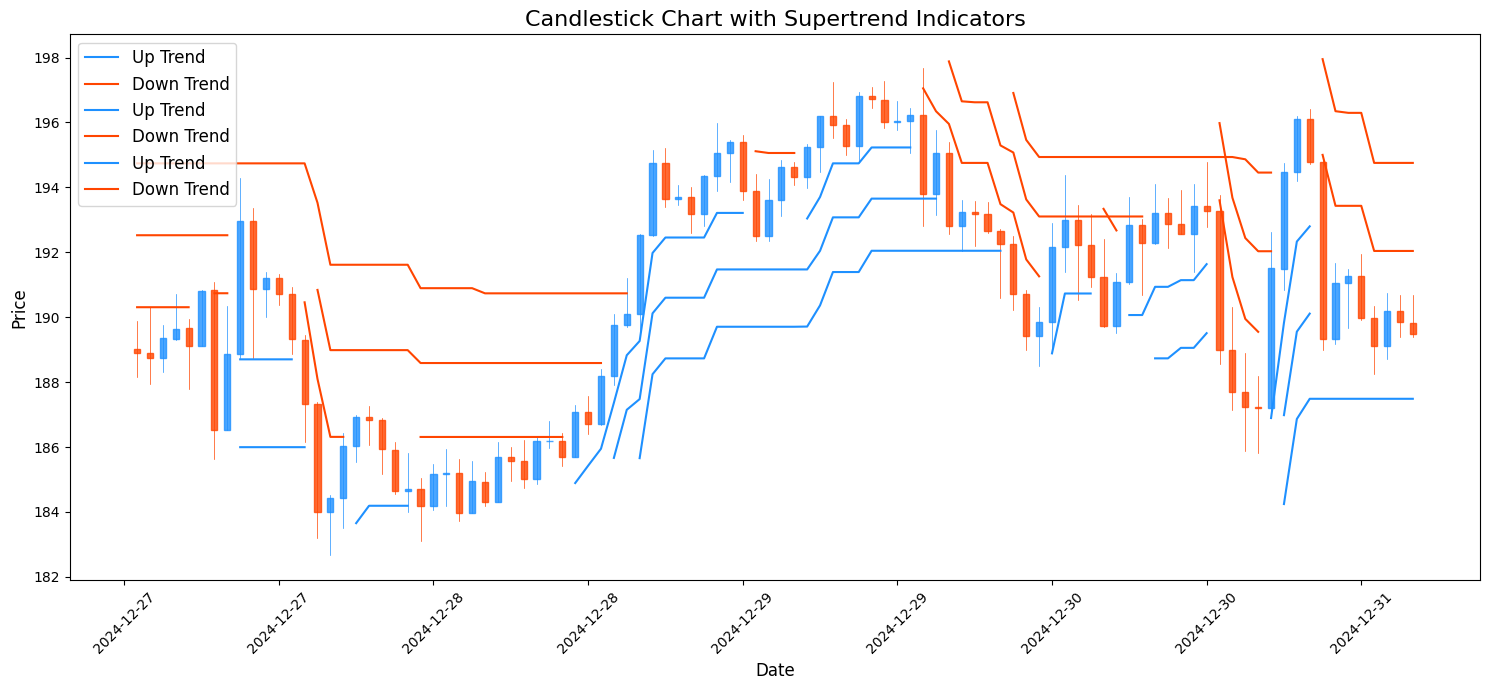

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
from mplfinance.original_flavor import candlestick_ohlc
import matplotlib.dates as mdates

# Assuming `supertrend_df` is already loaded
# Convert 'opentime' to datetime and set up plotting data
supertrend_df_sample['opentime'] = pd.to_datetime(supertrend_df_sample['opentime'], unit='ms')
supertrend_df_sample['date_num'] = mdates.date2num(supertrend_df_sample['opentime'])

# Prepare OHLC data for candlestick plot
ohlc = supertrend_df_sample[['date_num', 'openprice', 'highprice', 'lowprice', 'closeprice']].dropna().values

# Plot configuration
fig, ax = plt.subplots(figsize=(15, 7))
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)
plt.title('Candlestick Chart with Supertrend Indicators', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)

# Plot candlestick chart
candlestick_ohlc(ax, ohlc, width=0.02, colorup='dodgerblue', colordown='orangered', alpha=0.8)

# Plot SUPERTl_10_3.0 (green) and SUPERTs_10_3.0 (red)
ax.plot(supertrend_df_sample['date_num'], supertrend_df_sample['SUPERTl_12_3.0'], color='dodgerblue', label='Up Trend')
ax.plot(supertrend_df_sample['date_num'], supertrend_df_sample['SUPERTs_12_3.0'], color='orangered', label='Down Trend')

ax.plot(supertrend_df_sample['date_num'], supertrend_df_sample['SUPERTl_11_2.0'], color='dodgerblue', label='Up Trend')
ax.plot(supertrend_df_sample['date_num'], supertrend_df_sample['SUPERTs_11_2.0'], color='orangered', label='Down Trend')

ax.plot(supertrend_df_sample['date_num'], supertrend_df_sample['SUPERTl_10_1.0'], color='dodgerblue', label='Up Trend')
ax.plot(supertrend_df_sample['date_num'], supertrend_df_sample['SUPERTs_10_1.0'], color='orangered', label='Down Trend')

# Add legend
plt.legend(loc='upper left', fontsize=12)
plt.tight_layout()
plt.show()


# Backtest Signaling

In [33]:
df_backtest = supertrend_df.copy()

# Rename the last 4 columns
new_column_names = {
    'opentime': 'time',
    'openprice': 'open',
    'highprice': 'high',
    'lowprice': 'low',
    'closeprice': 'close'
    # 'SUPERTl_12_3.0': 'Up Trend 12',
    # 'SUPERTs_12_3.0': 'Down Trend 12',
    # 'SUPERTl_11_2.0': 'Up Trend 11',
    # 'SUPERTs_11_2.0': 'Down Trend 11',
    # 'SUPERTl_10_1.0': 'Up Trend 10',
    # 'SUPERTs_10_1.0': 'Down Trend 10',

}
df_backtest.rename(columns=new_column_names, inplace=True)

# Drop rows 0 to 12 becuase the longest supertrend is 12
df_backtest.drop(index=range(12), inplace=True)

df_backtest['trend_12'] = np.where(df_backtest['SUPERTl_12_3.0'].notna(), 1, 0)
df_backtest['trend_11'] = np.where(df_backtest['SUPERTl_11_2.0'].notna(), 1, 0)
df_backtest['trend_10'] = np.where(df_backtest['SUPERTl_10_1.0'].notna(), 1, 0)

# Drop unnecessary columns
df_backtest.drop(columns=(['SUPERTl_12_3.0','SUPERTs_12_3.0','SUPERTl_11_2.0','SUPERTs_11_2.0','SUPERTl_10_1.0','SUPERTs_10_1.0']), inplace=True)

df_backtest.reset_index(drop=True,inplace=True)

df_backtest

,time,open,high,low,close,trend_12,trend_11,trend_10
0,1600110000000,3.2878,3.3600,3.2224,3.3009,1,1,1
1,1600113600000,3.3012,3.3471,3.2400,3.2522,1,1,1
2,1600117200000,3.2505,3.2847,3.2440,3.2695,1,1,1
3,1600120800000,3.2694,3.3009,3.2555,3.2718,1,1,1
4,1600124400000,3.2718,3.3000,3.2526,3.2661,1,1,1
...,...,...,...,...,...,...,...,...
37637,1735603200000,191.2600,191.9600,189.9000,189.9800,1,0,0
37638,1735606800000,189.9900,190.3600,188.2400,189.1000,1,0,0
37639,1735610400000,189.1000,190.7500,188.7100,190.1900,1,0,0
37640,1735614000000,190.1900,190.6900,189.3900,189.8400,1,0,0


In [36]:
# Define Long/Short
df_backtest['action'] = np.where(
    (df_backtest['trend_12'] == 1) & 
    (df_backtest['trend_11'] == 1) & 
    (df_backtest['trend_10'] == 1),
    'long',
    np.where(
        (df_backtest['trend_12'] == 0) & 
        (df_backtest['trend_11'] == 0) & 
        (df_backtest['trend_10'] == 0),
        'short',
        None  # Default action if neither condition is met
    )
)

# Define Position Closing
df_backtest['action'] = np.where(
    (df_backtest['action'].isna()) & (df_backtest['action'].shift(1) == 'long'),
    'close_long',
    np.where(
        (df_backtest['action'].isna()) & (df_backtest['action'].shift(1) == 'short'),
        'close_short',
        df_backtest['action']  # Keep the current action if no condition is met
    )
)

df_backtest

,time,open,high,low,close,trend_12,trend_11,trend_10,action
0,1600110000000,3.2878,3.3600,3.2224,3.3009,1,1,1,long
1,1600113600000,3.3012,3.3471,3.2400,3.2522,1,1,1,long
2,1600117200000,3.2505,3.2847,3.2440,3.2695,1,1,1,long
3,1600120800000,3.2694,3.3009,3.2555,3.2718,1,1,1,long
4,1600124400000,3.2718,3.3000,3.2526,3.2661,1,1,1,long
...,...,...,...,...,...,...,...,...,...
37637,1735603200000,191.2600,191.9600,189.9000,189.9800,1,0,0,None
37638,1735606800000,189.9900,190.3600,188.2400,189.1000,1,0,0,None
37639,1735610400000,189.1000,190.7500,188.7100,190.1900,1,0,0,None
37640,1735614000000,190.1900,190.6900,189.3900,189.8400,1,0,0,None


In [37]:
df_backtest.head(50)

,time,open,high,low,close,trend_12,trend_11,trend_10,action
0,1600110000000,3.2878,3.3600,3.2224,3.3009,1,1,1,long
1,1600113600000,3.3012,3.3471,3.2400,3.2522,1,1,1,long
2,1600117200000,3.2505,3.2847,3.2440,3.2695,1,1,1,long
3,1600120800000,3.2694,3.3009,3.2555,3.2718,1,1,1,long
4,1600124400000,3.2718,3.3000,3.2526,3.2661,1,1,1,long
5,1600128000000,3.2629,3.2965,3.2440,3.2662,1,1,1,long
6,1600131600000,3.2668,3.3096,3.2566,3.2727,1,1,1,long
7,1600135200000,3.2726,3.3258,3.2577,3.2960,1,1,1,long
8,1600138800000,3.2953,3.3035,3.2446,3.2550,1,1,1,long
9,1600142400000,3.2563,3.2758,3.2444,3.2555,1,1,1,long


In [35]:
import numpy as np

# Set 'super_trend' to 1 if 'Down Trend' is NaN, and to 0 if 'Up Trend' is NaN
df_backtest['super_trend'] = np.where(df_backtest['Down Trend'].isna(), 1, 
                                      np.where(df_backtest['Up Trend'].isna(), -1, np.nan))

# Define a function to determine the action suggestion for each row
def determine_criteria_pass(row):
    if row['super_trend'] == 1 and row['open'] > max(row['Leading Span A'], row['Leading Span B']):
        return 1
    elif row['super_trend'] == -1 and row['open'] < min(row['Leading Span A'], row['Leading Span B']):
        return 1
    return 0

# Apply the function row-wise to the DataFrame
df_backtest['criteria'] = df_backtest.apply(determine_criteria_pass, axis=1)

# Initialize 'action' column to None
df_backtest['action'] = None

# Assign 'long' where super_trend == 1 and criteria == 1
df_backtest['action'] = np.where(
    (df_backtest['super_trend'] == 1) & (df_backtest['criteria'] == 1),
    'long',
    df_backtest['action']
)

# Assign 'short' where super_trend == -1 and criteria == 1
df_backtest['action'] = np.where(
    (df_backtest['super_trend'] == -1) & (df_backtest['criteria'] == 1),
    'short',
    df_backtest['action']
)

# Assign 'close' where super_trend changes (shifted value not equal to current value)
df_backtest['trend_change'] = np.where(
    df_backtest['super_trend'].shift(1) != df_backtest['super_trend'],
    1,
    0
)

df_backtest['time'] = (df_backtest['time']/1000).astype(int)

df_backtest

,time,open,high,low,close,Up Trend,Down Trend,Leading Span A,Leading Span B,super_trend,criteria,action,trend_change
0,1578020400,126.90,127.00,126.59,126.76,NaN,129.001617,131.0200,NaN,-1.0,1,short,1
1,1578024000,126.81,130.18,126.81,129.23,125.186485,NaN,130.7400,NaN,1.0,0,None,1
2,1578027600,129.23,129.95,128.69,129.18,125.964159,NaN,130.6775,NaN,1.0,0,None,0
3,1578031200,129.18,129.31,128.75,129.16,125.964159,NaN,130.6375,NaN,1.0,0,None,0
4,1578034800,129.15,129.43,128.69,128.82,125.969376,NaN,130.6375,NaN,1.0,0,None,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
43610,1735016400,3412.22,3433.99,3406.96,3422.61,3287.806533,NaN,3296.8525,3384.285,1.0,1,long,0
43611,1735020000,3422.62,3425.89,3384.52,3391.88,3287.806533,NaN,3298.5950,3384.285,1.0,1,long,0
43612,1735023600,3391.87,3414.65,3383.49,3399.92,3287.806533,NaN,3298.5950,3384.285,1.0,1,long,0
43613,1735027200,3399.91,3415.41,3391.82,3411.98,3287.806533,NaN,3298.5950,3384.285,1.0,1,long,0


In [36]:
# Get the backtest trade history
df_action_close = df_backtest[df_backtest['trend_change'] == 1]

# Generate consecutive row index pairs
index_list = df_action_close.index.tolist()
consecutive_pairs = [(index_list[i], index_list[i + 1]) for i in range(len(index_list) - 1)]

consecutive_pairs

# Create a function to process each pair
def process_consecutive_pairs(df_backtest, consecutive_pairs):
    result_pairs = []

    for start_idx, end_idx in consecutive_pairs:
        # Slice the dataframe between the two indices (inclusive)
        sub_df = df_backtest.iloc[start_idx:end_idx+1]
        
        # Check if there is any "short" or "long" action in the 'action' column
        actions = sub_df['action']
        long_short_indices = actions[actions.isin(['long', 'short'])]

        if not long_short_indices.empty:
            # Note the first occurrence nearest to the first index of the pair
            first_action_idx = long_short_indices.index[0]
            # Add the result as a tuple (first action index, second close index)
            result_pairs.append((first_action_idx, end_idx))

    return result_pairs

# Call the function with your DataFrame and consecutive_pairs
result = process_consecutive_pairs(df_backtest, consecutive_pairs)

# Function to drop pairs where both indices are the same
def remove_duplicate_indices(pairs):
    return [(start_idx, end_idx) for start_idx, end_idx in pairs if start_idx != end_idx]

# Apply the function to the result list
filtered_result = remove_duplicate_indices(result)

# Create the result DataFrame
results = []
for start_idx, end_idx in filtered_result:
    position = df_backtest.loc[start_idx, 'action']
    open_time = df_backtest.loc[start_idx, 'time']
    open_price = df_backtest.loc[start_idx, 'open']
    exit_time = df_backtest.loc[end_idx, 'time']
    exit_price = df_backtest.loc[end_idx, 'close']
    
    # Slice the DataFrame between start_idx and end_idx (inclusive)
    sub_df = df_backtest.iloc[start_idx:end_idx + 1]
    min_price = sub_df['low'].min()
    max_price = sub_df['high'].max()
    
    results.append({
        "position": position,
        "open_time": open_time,
        "open_price": open_price,
        "exit_time": exit_time,
        "exit_price": exit_price,
        "min_price": min_price,
        "max_price": max_price
    })

backtest_trade_recap = pd.DataFrame(results)

# Display the recap DataFrame
backtest_trade_recap

,position,open_time,open_price,exit_time,exit_price,min_price,max_price
0,short,1578020400,126.90,1578024000,129.23,126.59,130.18
1,long,1578042000,132.12,1578409200,139.46,130.94,145.25
2,long,1578427200,143.18,1578499200,138.90,137.95,147.94
3,short,1578502800,138.96,1578657600,139.76,135.22,141.52
4,long,1578679200,141.96,1579431600,166.87,141.49,179.57
...,...,...,...,...,...,...,...
807,long,1733929200,3769.24,1734199200,3832.46,3752.48,3986.94
808,short,1734202800,3832.46,1734303600,3958.50,3822.37,3973.67
809,long,1734307200,3958.50,1734458400,3929.56,3882.22,4109.99
810,short,1734462000,3929.57,1734714000,3435.98,3100.00,3953.40


# Back Test Simulation

In [37]:
import numpy as np
import pandas as pd

# Copy the backtest_trade_recap DataFrame
backtest_trade_sim = backtest_trade_recap.copy()

# Initialize columns
backtest_trade_sim['quantity'] = 1000  # Base quantity per trade
backtest_trade_sim['leverage'] = 1    # Default leverage (e.g., 10x)
backtest_trade_sim['open_fee'] = 0
backtest_trade_sim['exit_fee'] = 0
backtest_trade_sim['realized_pnl'] = 0
backtest_trade_sim['max_drawdown_percent'] = 0  # Column for max drawdown % calculation

# Define the taker fee and funding rate
taker_fee = 0.0005  # 0.05% futures
funding_rate = 0.0001  # 0.01%

# Adjust quantity based on leverage
backtest_trade_sim['leveraged_quantity'] = backtest_trade_sim['quantity'] * backtest_trade_sim['leverage']

# Calculate open_fee
backtest_trade_sim['open_fee'] = backtest_trade_sim['leveraged_quantity'] * taker_fee

# Calculate exit_fee
backtest_trade_sim['exit_fee'] = (
    (backtest_trade_sim['leveraged_quantity'] / backtest_trade_sim['open_price']) * 
    backtest_trade_sim['exit_price'] * taker_fee
)

# Calculate position hold time
backtest_trade_sim['hold_time'] = (backtest_trade_sim['exit_time'] - backtest_trade_sim['open_time']) / 3600

# Calculate funding_fee occurrences and total funding_fee
backtest_trade_sim['funding_fee_occurence'] = backtest_trade_sim['hold_time'] // 8
backtest_trade_sim['funding_fee'] = (
    backtest_trade_sim['leveraged_quantity'] * backtest_trade_sim['funding_fee_occurence'] * funding_rate
)

# Calculate max drawdown (in %), accounting for leverage
def calculate_max_drawdown(row):
    if row['position'] == 'long':
        # For Long, calculate max drawdown from open price to min price
        max_drawdown = (row['min_price'] - row['open_price']) / row['open_price'] * 100
    elif row['position'] == 'short':
        # For Short, calculate max drawdown from open price to max price
        max_drawdown = (row['open_price'] - row['max_price']) / row['open_price'] * 100
    else:
        return 0  # Default case, should not be reached
    
    # Include leverage to magnify the effect of drawdown
    max_drawdown_leverage = max_drawdown * row['leverage']  # Leverage magnifies the drawdown
    
    return max_drawdown_leverage

backtest_trade_sim['max_drawdown_percent'] = backtest_trade_sim.apply(calculate_max_drawdown, axis=1)

# Calculate realized_pnl
def calculate_realized_pnl(row):
    position = row['position']
    leveraged_quantity = row['leveraged_quantity']
    open_price = row['open_price']
    exit_price = row['exit_price']
    open_fee = row['open_fee']
    exit_fee = row['exit_fee']
    funding_fee = row['funding_fee']
    
    if position == 'short':
        return leveraged_quantity - (leveraged_quantity / open_price * exit_price) - open_fee - exit_fee - funding_fee
    elif position == 'long':
        return (leveraged_quantity / open_price * exit_price) - leveraged_quantity - open_fee - exit_fee - funding_fee
    return 0  # Default case, should not be reached

backtest_trade_sim['realized_pnl'] = backtest_trade_sim.apply(calculate_realized_pnl, axis=1)

# Calculate cumulative realized profit and loss
backtest_trade_sim['cumulative_realized_pnl'] = backtest_trade_sim['realized_pnl'].cumsum()

# Define trade win/loss
backtest_trade_sim['win_loss'] = np.where(backtest_trade_sim['realized_pnl'] >= 0, 'Win', 'Lose')

# Display specific columns
backtest_trade_sim[['position', 'open_time', 'open_price', 'exit_time', 'exit_price', 'min_price', 'max_price', 
                          'realized_pnl', 'max_drawdown_percent', 'leveraged_quantity', 'cumulative_realized_pnl', 'win_loss']]

,position,open_time,open_price,exit_time,exit_price,min_price,max_price,realized_pnl,max_drawdown_percent,leveraged_quantity,cumulative_realized_pnl,win_loss
0,short,1578020400,126.90,1578024000,129.23,126.59,130.18,-19.370095,-2.584712,1000,-19.370095,Lose
1,long,1578042000,132.12,1578409200,139.46,130.94,145.25,53.327778,-0.893127,1000,33.957683,Win
2,long,1578427200,143.18,1578499200,138.90,137.95,147.94,-31.077497,-3.652745,1000,2.880186,Lose
3,short,1578502800,138.96,1578657600,139.76,135.22,141.52,-7.259931,-1.842257,1000,-4.379745,Lose
4,long,1578679200,141.96,1579431600,166.87,141.49,179.57,171.784228,-0.331079,1000,167.404483,Win
...,...,...,...,...,...,...,...,...,...,...,...,...
807,long,1733929200,3769.24,1734199200,3832.46,3752.48,3986.94,14.864226,-0.444652,1000,4938.049147,Win
808,short,1734202800,3832.46,1734303600,3958.50,3822.37,3973.67,-34.203936,-3.684579,1000,4903.845211,Lose
809,long,1734307200,3958.50,1734458400,3929.56,3882.22,4109.99,-8.807195,-1.926993,1000,4895.038016,Lose
810,short,1734462000,3929.57,1734714000,3435.98,3100.00,3953.40,123.871968,-0.606428,1000,5018.909984,Win


## Static Balance

In [38]:
# Calculate trade simulation
backtest_trade_sim = backtest_trade_recap.copy()

backtest_trade_sim['balance'] = 1000
backtest_trade_sim['open_fee'] = 0
backtest_trade_sim['exit_fee'] = 0
backtest_trade_sim['realized_pnl'] = 0

# Define the taker fee (e.g., 0.001 for 0.1%)
taker_fee = 0.0005 # 0.05% futures
# taker_fee = 0.001 # 0.1% spot

# Define Funding rate
funding_rate = 0.0001 #0.01%

# Calculate open_fee
backtest_trade_sim['open_fee'] = backtest_trade_sim['balance'] * taker_fee

# Calculate exit_fee
backtest_trade_sim['exit_fee'] = (
    (backtest_trade_sim['balance'] / backtest_trade_sim['open_price']) * 
    backtest_trade_sim['exit_price'] * taker_fee
)

# Calculate position hold time
backtest_trade_sim['hold_time'] = (backtest_trade_sim['exit_time'] - backtest_trade_sim['open_time']) / 3600

# Calculate how many times it need to pay funding_fee
backtest_trade_sim['funding_fee_occurence'] = backtest_trade_sim['hold_time'] // 8

# Calculate funding_fee
backtest_trade_sim['funding_fee'] = backtest_trade_sim['balance'] * backtest_trade_sim['funding_fee_occurence'] * funding_rate

# Calculate realized_pnl
def calculate_realized_pnl(row):
    position = row['position']
    balance = row['balance']
    open_price = row['open_price']
    exit_price = row['exit_price']
    open_fee = row['open_fee']
    exit_fee = row['exit_fee']
    funding_fee = row['funding_fee']
    
    if position == 'short':
        return balance - (balance / open_price * exit_price) - open_fee - exit_fee - funding_fee
    elif position == 'long':
        return (balance / open_price * exit_price) - balance - open_fee - exit_fee - funding_fee
    return 0  # Default case, should not be reached

backtest_trade_sim['realized_pnl'] = backtest_trade_sim.apply(calculate_realized_pnl, axis=1)

# Calculate cumulative realized profit and loss
backtest_trade_sim['cumulative_realized_pnl'] = backtest_trade_sim['realized_pnl'].cumsum()

# Define trade win/loss
backtest_trade_sim['win_loss'] = np.where(backtest_trade_sim['realized_pnl'] >= 0, 'Win', 'Lose')

# Display the updated DataFrame
backtest_trade_sim

,position,open_time,open_price,exit_time,exit_price,min_price,max_price,balance,open_fee,exit_fee,realized_pnl,hold_time,funding_fee_occurence,funding_fee,cumulative_realized_pnl,win_loss
0,short,1578020400,126.90,1578024000,129.23,126.59,130.18,1000,0.5,0.509180,-19.370095,1.0,0.0,0.0,-19.370095,Lose
1,long,1578042000,132.12,1578409200,139.46,130.94,145.25,1000,0.5,0.527778,53.327778,102.0,12.0,1.2,33.957683,Win
2,long,1578427200,143.18,1578499200,138.90,137.95,147.94,1000,0.5,0.485054,-31.077497,20.0,2.0,0.2,2.880186,Lose
3,short,1578502800,138.96,1578657600,139.76,135.22,141.52,1000,0.5,0.502879,-7.259931,43.0,5.0,0.5,-4.379745,Lose
4,long,1578679200,141.96,1579431600,166.87,141.49,179.57,1000,0.5,0.587736,171.784228,209.0,26.0,2.6,167.404483,Win
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
807,long,1733929200,3769.24,1734199200,3832.46,3752.48,3986.94,1000,0.5,0.508386,14.864226,75.0,9.0,0.9,4938.049147,Win
808,short,1734202800,3832.46,1734303600,3958.50,3822.37,3973.67,1000,0.5,0.516444,-34.203936,28.0,3.0,0.3,4903.845211,Lose
809,long,1734307200,3958.50,1734458400,3929.56,3882.22,4109.99,1000,0.5,0.496345,-8.807195,42.0,5.0,0.5,4895.038016,Lose
810,short,1734462000,3929.57,1734714000,3435.98,3100.00,3953.40,1000,0.5,0.437195,123.871968,70.0,8.0,0.8,5018.909984,Win


In [39]:
import pandas as pd

# Count of positions (number and percentage)
position_counts = backtest_trade_sim['position'].value_counts()
position_percentages = position_counts / len(backtest_trade_sim) * 100

# Realized PnL statistics
realized_pnl_stats = {
    'max': backtest_trade_sim['realized_pnl'].max(),
    'min': backtest_trade_sim['realized_pnl'].min(),
    'avg': backtest_trade_sim['realized_pnl'].mean(),
    'median': backtest_trade_sim['realized_pnl'].median(),
}

# Win rate (overall)
total_trades = len(backtest_trade_sim)
wins = (backtest_trade_sim['realized_pnl'] >= 0).sum()
win_rate = wins / total_trades * 100

# Win rate per position (long/short)
win_rate_by_position = (
    backtest_trade_sim.groupby('position')['realized_pnl']
    .apply(lambda x: (x >= 0).sum() / len(x) * 100)
)

# Results
results = {
    "Position Counts": position_counts.to_dict(),
    "Position Percentages": position_percentages.to_dict(),
    "Realized PnL Stats": realized_pnl_stats,
    "Overall Win Rate": win_rate,
    "Win Rate by Position": win_rate_by_position.to_dict(),
}

# Display results
results

{'Position Counts': {'long': 425, 'short': 387},
 'Position Percentages': {'long': 52.33990147783252,
  'short': 47.66009852216749},
 'Realized PnL Stats': {'max': np.float64(587.9774852362204),
  'min': np.float64(-118.49293211311212),
  'avg': np.float64(6.155098794776443),
  'median': np.float64(-8.818734337959135)},
 'Overall Win Rate': np.float64(38.30049261083744),
 'Win Rate by Position': {'long': 42.35294117647059,
  'short': 33.850129198966414}}

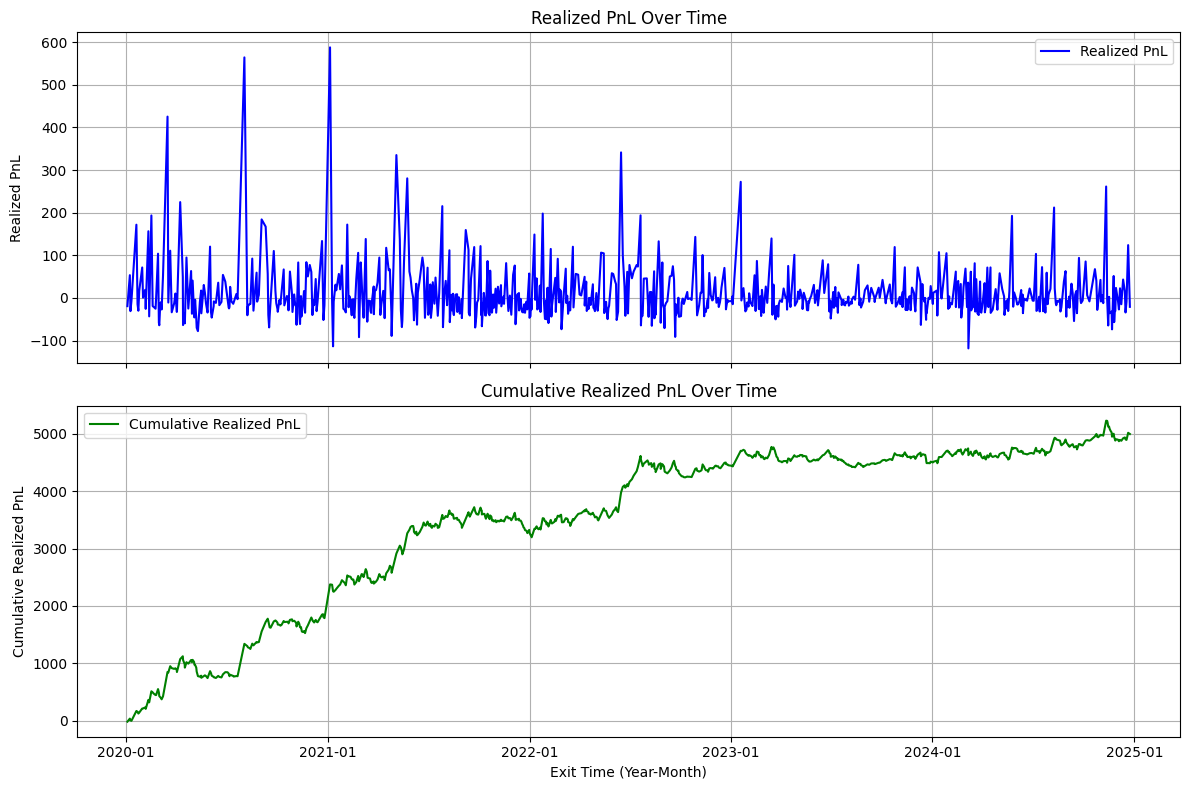

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

backtest_trade_sim_plot = backtest_trade_sim.copy()

# Convert exit_time from UNIX milliseconds to UTC+0 datetime
backtest_trade_sim_plot['exit_time_utc'] = pd.to_datetime(
    backtest_trade_sim_plot['exit_time'], unit='s', utc=True
)

# Plotting
fig, ax = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Realized PnL vs Exit Time
ax[0].plot(backtest_trade_sim_plot['exit_time_utc'], backtest_trade_sim_plot['realized_pnl'], label='Realized PnL', color='blue')
ax[0].set_title('Realized PnL Over Time')
ax[0].set_ylabel('Realized PnL')

# Cumulative Realized PnL vs Exit Time
ax[1].plot(backtest_trade_sim_plot['exit_time_utc'], backtest_trade_sim_plot['cumulative_realized_pnl'], label='Cumulative Realized PnL', color='green')
ax[1].set_title('Cumulative Realized PnL Over Time')
ax[1].set_ylabel('Cumulative Realized PnL')

# Format x-axis to show year and month
ax[1].xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))
ax[1].set_xlabel('Exit Time (Year-Month)')

# Improve layout and add gridlines
for axis in ax:
    axis.grid(True)
    axis.legend()

plt.tight_layout()
plt.show()